<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/main/Optimization/DecisionTree_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

# Import phase I data

Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
import time
%alias_magic t timeit
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Gadget 2 Data / with Neutrino

In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/denc_Neutrino')
# data['in_halo'] = (data['haloID']>0).astype('int')
data['in_halo'] = (data['halo_mass']>1600).astype('int32')
data

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,10156552,755,2280.0,171.21194,220.56293,-274.228700,-0.084922,-0.052028,-0.042415,-0.028087,-0.024984,-0.018675,-0.016231,-0.011940,-0.010111,1
1,11068486,85,1539.0,-129.84116,92.60424,212.125500,-0.127820,-0.081099,-0.051217,-0.028345,-0.013751,-0.013991,-0.012344,-0.011500,-0.012220,0
2,9530036,654,1944.0,-290.99210,-885.49430,468.255040,-0.078978,-0.052806,-0.030027,-0.011704,0.001295,0.003803,0.005131,0.005231,0.003787,1
3,11455022,752,1394.0,-60.35258,422.43716,79.394300,-0.109989,-0.079155,-0.054663,-0.037685,-0.026670,-0.017901,-0.009227,-0.000868,0.001568,0
4,8591034,356,1649.0,403.66608,345.88077,9.231552,-0.084405,-0.019068,-0.009396,-0.001539,0.002288,0.005629,0.011288,0.013111,0.013433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2160800,451,2634.0,654.82430,210.78130,255.344150,-0.094225,-0.076043,-0.060624,-0.040368,-0.020840,-0.016261,-0.011803,-0.005002,0.000918,1
99996,3257728,43,1112.0,-154.27774,488.65564,-779.558400,-0.127045,-0.076529,-0.056246,-0.038201,-0.027520,-0.016374,-0.008045,0.002627,0.006124,0
99997,6101605,484,1198.0,-113.51735,68.44336,275.964000,-0.122135,-0.091794,-0.063465,-0.032060,-0.017973,-0.016684,-0.017740,-0.017154,-0.012600,0
99998,4576456,44,1058.0,-130.21120,292.63483,-754.563000,-0.097585,-0.076140,-0.061788,-0.054584,-0.043055,-0.032415,-0.021591,-0.007463,0.004673,0


In [ ]:
data.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.716004e+06,424.627710,2369.299450,35.207601,-13.728656,97.821939,-0.107338,-0.062074,-0.038666,-0.025951,-0.017900,-0.011968,-0.007224,-0.003341,-0.000224,0.557930
std,3.549230e+06,230.962533,1856.527585,364.820655,369.919751,373.578625,0.020301,0.020965,0.019921,0.018106,0.015956,0.013969,0.012346,0.011069,0.010084,0.496635
min,2.131444e+06,16.000000,241.000000,-1247.932500,-1462.806300,-1250.519700,-0.127820,-0.099572,-0.083351,-0.072824,-0.065316,-0.058751,-0.050519,-0.043771,-0.038371,0.000000
25%,5.953820e+06,238.000000,1194.000000,-226.284345,-254.656135,-145.829085,-0.124202,-0.077891,-0.052474,-0.038510,-0.028860,-0.021233,-0.015384,-0.010712,-0.006964,0.000000
50%,9.043250e+06,418.000000,1791.000000,32.857450,-4.815737,101.883413,-0.113607,-0.063404,-0.039434,-0.026100,-0.017784,-0.011980,-0.007369,-0.003743,-0.000713,1.000000
75%,1.176120e+07,619.000000,2945.000000,284.168098,238.543252,350.062135,-0.095776,-0.048722,-0.025370,-0.013587,-0.006677,-0.002087,0.001081,0.004249,0.006694,1.000000
max,1.464652e+07,870.000000,10101.000000,1314.092800,1256.822900,1355.984900,0.017155,0.032463,0.044346,0.040490,0.042179,0.036009,0.033482,0.034145,0.032602,1.000000


### Gadget 2 Data / without Neutrino

In [ ]:
data_cdm = pd.read_csv(r'/content/drive/MyDrive/denc_CDM')
data_cdm['in_halo'] = (data_cdm['halo_mass']>1600).astype('int32')
data_cdm

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,8981131,414,1504.0,252.710050,-464.239500,509.94550,2.817576,2.780794,2.746420,2.446413,2.000415,1.533108,1.083378,0.691070,0.457584,0
1,9901676,1026,1013.0,-167.701370,499.161740,156.32635,2.690323,2.102417,1.805493,1.485764,1.267945,1.083753,0.849938,0.617267,0.431845,0
2,8288987,1079,727.0,46.129280,19.954561,164.61870,1.010590,0.821528,0.559744,0.220796,0.003400,-0.094805,-0.074599,0.003315,0.076079,0
3,4842631,675,1268.0,-234.629320,349.021400,-690.46674,1.889611,1.180236,0.495534,0.064434,-0.232441,-0.389582,-0.407908,-0.334146,-0.231578,0
4,12884124,437,6128.0,146.780670,-180.209270,-558.39777,2.676619,1.734870,0.906903,0.464721,0.187801,0.057663,0.029529,0.049055,0.101472,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12466311,1085,5542.0,25.253933,-580.586850,113.06337,1.482403,1.068278,0.857863,0.583947,0.327563,0.212553,0.139374,0.103515,0.090791,1
99996,11857185,491,691.0,-423.371550,138.109020,-300.80450,-0.209077,-0.534490,-0.724460,-0.749430,-0.743152,-0.663805,-0.511928,-0.347015,-0.253660,0
99997,9340191,947,868.0,225.385210,-9.085627,318.22006,1.086942,0.492283,0.114506,-0.050883,-0.161068,-0.168421,-0.159639,-0.175261,-0.202931,0
99998,13317963,1034,1175.0,-55.431606,16.332230,-898.90326,0.339088,-0.085185,-0.248881,-0.328230,-0.343797,-0.306353,-0.275684,-0.282089,-0.284524,0


In [ ]:
data_cdm.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.533738e+06,633.075900,3004.391080,32.287533,-13.697343,89.574071,1.423915,1.032233,0.712873,0.480862,0.322917,0.216223,0.144046,0.096634,0.066060,0.589200
std,3.598448e+06,358.496156,2802.876192,359.880883,364.383569,374.571567,1.023549,0.920945,0.807251,0.689640,0.585773,0.502089,0.436403,0.384151,0.341271,0.491981
min,2.131195e+06,3.000000,271.000000,-1234.874100,-1571.376600,-1311.024700,-0.994127,-0.912349,-0.878283,-0.891915,-0.933043,-0.935449,-0.868262,-0.815454,-0.787467,0.000000
25%,5.640789e+06,368.000000,1181.000000,-223.982345,-249.685410,-148.388917,0.660156,0.354545,0.122621,-0.026842,-0.107359,-0.161173,-0.183527,-0.186967,-0.181568,0.000000
50%,8.790886e+06,676.000000,2020.000000,28.124724,-4.978945,97.944227,1.269011,0.890765,0.589027,0.370513,0.223129,0.134561,0.074502,0.037988,0.011761,1.000000
75%,1.143724e+07,970.000000,3662.000000,277.156240,231.618633,341.305498,2.057976,1.549992,1.162333,0.872826,0.674880,0.526476,0.422276,0.353801,0.294427,1.000000
max,1.464654e+07,1251.000000,31252.000000,1362.093800,1185.835400,1349.211900,5.624963,4.721646,3.972765,3.400808,2.783131,2.163220,1.888203,1.618024,1.364662,1.000000


## Define Datasets

In [ ]:
## Neutrino
X = data.iloc[:,3:15].astype('float32').values
Y = data.in_halo.astype('int32').values

In [ ]:
## CDM
X2 = data_cdm.iloc[:,3:15].astype('float32').values
Y2 = data_cdm.in_halo.astype('int32').values

In [ ]:
## Scale / Neutrino
X = (X - np.mean(X))/np.std(X)

In [ ]:
## Scale / CDM
X2 = (X2 - np.mean(X2))/np.std(X2)

In [ ]:
## Split into test and train / Neutrino

tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 80000    X_test : 20000


In [ ]:
## Split into test and train / CDM

tst_size = 0.2
ns, nf = np.shape(X) 
X2_train, X2_test, Y2_train, Y2_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X2_train :',len(X2_train),'   X2_test :',len(X2_test))

X2_train : 80000    X2_test : 20000


In [ ]:
# Frequency of 1-class / Neutrino
print("{} % of the stored data has class 1 ".format(100*Y.sum()/len(Y)))

55.793 % of the stored data has class 1 


In [ ]:
# Frequency of 1-class / CDM
print("{} % of the stored data has class 1 ".format(100*Y2.sum()/len(Y2)))

58.92 % of the stored data has class 1 


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics

clf = DecisionTreeClassifier(max_depth=20)
%t clf.fit(X_train,Y_train)
Y_pred_dt = clf.predict(X_test)

print(metrics.accuracy_score(Y_test, Y_pred_dt))

1 loop, best of 5: 2.78 s per loop
0.7442


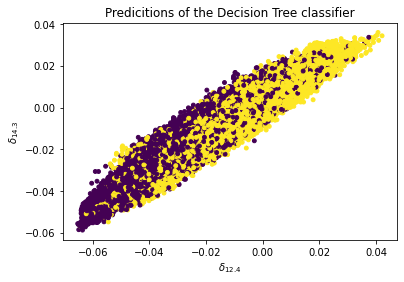

In [ ]:
clf = DecisionTreeClassifier(max_depth=20)
clf = clf.fit(X_train,Y_train)
plt.scatter(data['dc for 12.4'],data['dc for 14.3'],c=clf.predict(X),s=15)
plt.xlabel('$ \delta_{12.4} $')
plt.ylabel('$\delta_{14.3} $')
plt.title('Predicitions of the Decision Tree classifier')
plt.show()

### Validation Curve

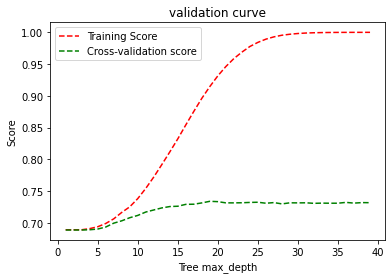

Best max_depth = 19


In [ ]:
from sklearn.model_selection import validation_curve


param_range = np.arange(1, 40, 1)

train_scores, test_scores = validation_curve(
    clf, X=X_train, y=Y_train,cv=5, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=1)


train_scores_mean = np.mean(train_scores, axis=1)
#train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
#test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,'r--',label = 'Training Score')
plt.plot(param_range, test_scores_mean,'g--',label = 'Cross-validation score')

plt.title('validation curve')
plt.xlabel('Tree max_depth')
plt.ylabel('Score')
plt.legend(loc='upper left')

plt.show()
print(f'Best max_depth = {np.argmax(test_scores_mean) + 1}')

### Learning Curve

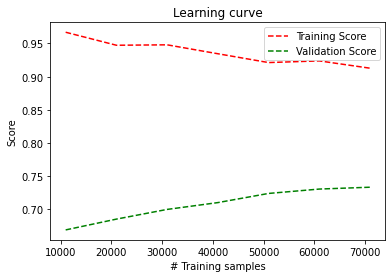

In [ ]:

from sklearn.model_selection import learning_curve

clf = DecisionTreeClassifier(max_depth=19)
clf.fit(X,Y)

train_sizes = np.arange(1000,80000,10000)

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= clf , X = X,
                                                   y = Y, train_sizes = train_sizes, cv = 5, random_state = 0)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

plt.title('Learning curve')
plt.plot(ns_list[1:], train_scores_mean[1:],'r--',label = 'Training Score')
plt.plot(ns_list[1:], validation_scores_mean[1:], 'g--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

In [ ]:
# best split
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = 100000, random_state=0) , random_state=0, test_size =.09)

### Fine Tuning The Model

In [ ]:
clf = DecisionTreeClassifier(max_depth=19)
start = time.time()
clf.fit(X_train,Y_train)
runtime_train = time.time() - start

start = time.time()
Y_pred_dt = clf.predict(X_test)
runtime_pred = time.time() - start


print(metrics.accuracy_score(Y_test, Y_pred_dt))

0.7517777777777778


### Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, clf.predict(X_test))
print(clf_report)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      4023
           1       0.77      0.78      0.78      4977

    accuracy                           0.75      9000
   macro avg       0.75      0.75      0.75      9000
weighted avg       0.75      0.75      0.75      9000



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y, clf.predict(X)))

[[38604  5603]
 [ 4996 50797]]


Confusion matrix, without normalization
[[38604  5603]
 [ 4996 50797]]
Normalized confusion matrix
[[0.87325537 0.12674463]
 [0.08954528 0.91045472]]


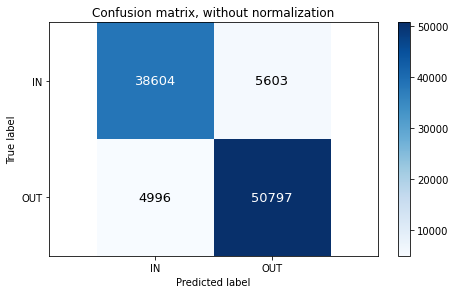

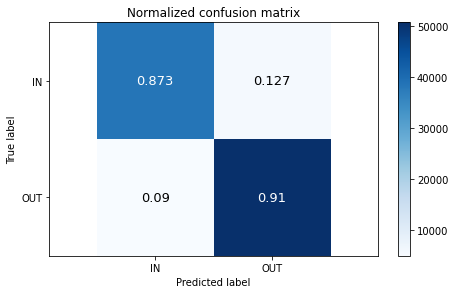

In [ ]:
import itertools

conf=confusion_matrix(Y, clf.predict(X))
class_names = {'IN' , 'OUT'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    #, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),
                 horizontalalignment='center',
                 verticalalignment='center',
                 #transform=ax.transAxes,
                 fontsize = 13,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.axis('equal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(Y, clf.predict(X), pos_label=0))
print(precision_score(Y, clf.predict(X), pos_label = 0))

0.8732553667971136
0.8854128440366973


### Precision-Recall curve

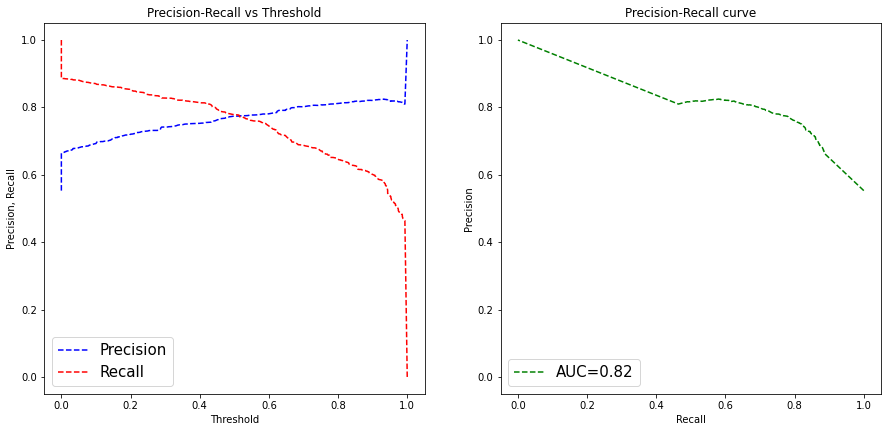

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.metrics import auc

Y_probs=clf.predict_proba(X_test) 
precision, recall, thresholds = precision_recall_curve(Y_test , Y_probs[:, 1]) 
thresholds=np.append(0,thresholds)

area = auc(recall, precision)
#print(area)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(221,xlabel='Threshold',ylabel='Precision, Recall' ,title='Precision-Recall vs Threshold')
ax1.plot(thresholds, precision, "b--", label="Precision")
ax1.plot(thresholds, recall, "r--", label="Recall")
plt.legend(loc="lower left",prop={'size': 15})

ax2 = plt.subplot(222,title='Precision-Recall curve',xlabel='Recall',ylabel='Precision')
ax2.plot( recall,precision,'g--',label='AUC={:.2f}'.format(area))
ax2.set( ylim=(-.05, 1.05))
plt.legend(loc="lower left",prop={'size': 15})

plt.show()

In [ ]:
EM1 = 'accuracy'
# mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS1 = accuracy_score(Y_train, clf.predict(X_train))
CPS1 = accuracy_score(Y_test, Y_pred_dt)
T1 = runtime_train
PT1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))

Training Time was: 2.81160044670105
Prediction Time was: 0.004653215408325195


# Dicision Tree / CDM

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics

clf = DecisionTreeClassifier(max_depth=20)
%t clf.fit(X2_train,Y2_train)
Y2_pred_dt = clf.predict(X2_test)

print(metrics.accuracy_score(Y2_test, Y2_pred_dt))

1 loop, best of 5: 1.73 s per loop
0.7449


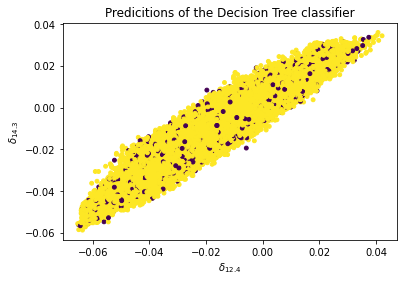

In [ ]:
clf = DecisionTreeClassifier(max_depth=20)
clf = clf.fit(X2_train,Y2_train)
plt.scatter(data['dc for 12.4'],data['dc for 14.3'],c=clf.predict(X2),s=15)
plt.xlabel('$ \delta_{12.4} $')
plt.ylabel('$\delta_{14.3} $')
plt.title('Predicitions of the Decision Tree classifier')
plt.show()

### Validation Curve

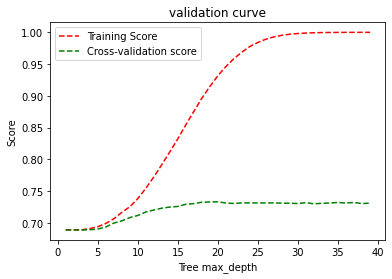

Best max_depth = 20


In [ ]:
from sklearn.model_selection import validation_curve


param_range = np.arange(1, 40, 1)

train_scores, test_scores = validation_curve(
    clf, X=X2_train, y=Y2_train,cv=5, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=1)


train_scores_mean = np.mean(train_scores, axis=1)
#train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
#test_scores_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_scores_mean,'r--',label = 'Training Score')
plt.plot(param_range, test_scores_mean,'g--',label = 'Cross-validation score')

plt.title('validation curve')
plt.xlabel('Tree max_depth')
plt.ylabel('Score')
plt.legend(loc='upper left')

plt.show()
print(f'Best max_depth = {np.argmax(test_scores_mean) + 1}')

### Learning Curve

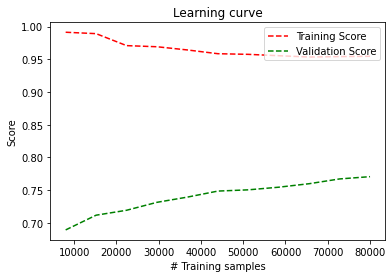

In [ ]:

from sklearn.model_selection import learning_curve

clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X2,Y2)

train_sizes = np.linspace(.01,1, num=12)

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= clf , X = X2,
                                                   y = Y2, train_sizes = train_sizes, cv = 5, random_state = 0)

train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

plt.title('Learning curve')
plt.plot(ns_list[1:], train_scores_mean[1:],'r--',label = 'Training Score')
plt.plot(ns_list[1:], validation_scores_mean[1:], 'g--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

In [ ]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.01, random_state=1)

### Fine Tuning The Model

In [ ]:
clf = DecisionTreeClassifier(max_depth=20)
start = time.time()
clf.fit(X2_train,Y2_train)
runtime_train = time.time() - start

start = time.time()
Y2_pred_dt = clf.predict(X2_test)
runtime_pred = time.time() - start

print(metrics.accuracy_score(Y2_test, Y2_pred_dt))

0.799


### Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y2_test, clf.predict(X2_test))
print(clf_report)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       424
           1       0.82      0.83      0.83       576

    accuracy                           0.80      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y2, clf.predict(X2)))

[[38646  2434]
 [ 2437 56483]]


Confusion matrix, without normalization
[[38646  2434]
 [ 2437 56483]]
Normalized confusion matrix
[[0.94074976 0.05925024]
 [0.04136117 0.95863883]]


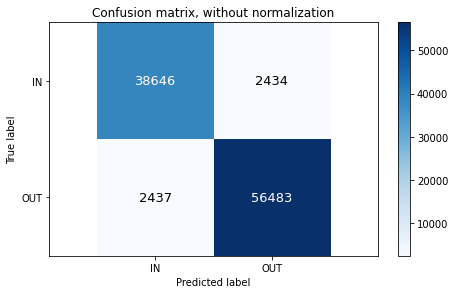

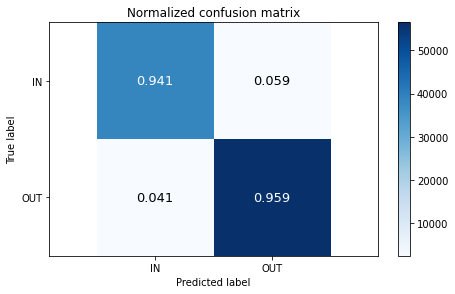

In [ ]:
import itertools

conf=confusion_matrix(Y2, clf.predict(X2))
class_names = {'IN' , 'OUT'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    #, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],3),
                 horizontalalignment='center',
                 verticalalignment='center',
                 #transform=ax.transAxes,
                 fontsize = 13,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.axis('equal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score
print(recall_score(Y2, clf.predict(X2), pos_label=0))
print(precision_score(Y2, clf.predict(X2), pos_label = 0))

0.9407497565725413
0.9406810602925785


### Precision-Recall curve

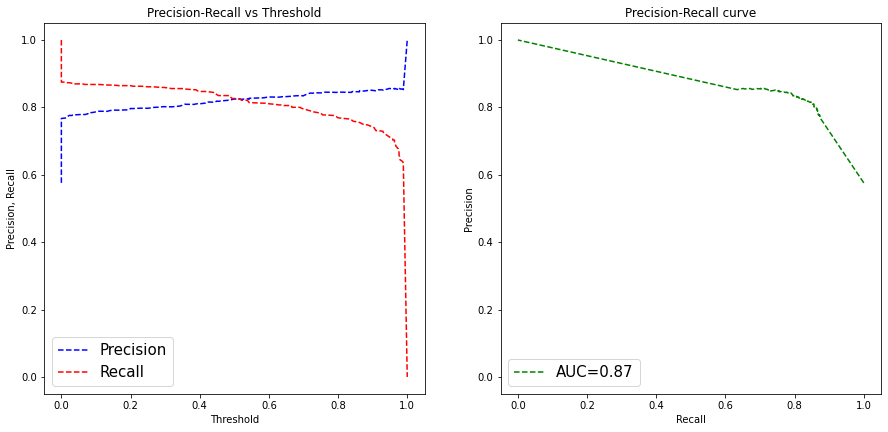

In [ ]:
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.metrics import auc

Y2_probs=clf.predict_proba(X2_test) 
precision, recall, thresholds = precision_recall_curve(Y2_test , Y2_probs[:, 1]) 
thresholds=np.append(0,thresholds)

area = auc(recall, precision)
#print(area)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(221,xlabel='Threshold',ylabel='Precision, Recall' ,title='Precision-Recall vs Threshold')
ax1.plot(thresholds, precision, "b--", label="Precision")
ax1.plot(thresholds, recall, "r--", label="Recall")
plt.legend(loc="lower left",prop={'size': 15})

ax2 = plt.subplot(222,title='Precision-Recall curve',xlabel='Recall',ylabel='Precision')
ax2.plot( recall,precision,'g--',label='AUC={:.2f}'.format(area))
ax2.set( ylim=(-.05, 1.05))
plt.legend(loc="lower left",prop={'size': 15})

plt.show()

In [ ]:
EM2 = 'accuracy'
# mean_test_scores = trained_model.cv_results_.get('mean_test_score')
CVS2 = accuracy_score(Y2_train, clf.predict(X2_train))
CPS2 = accuracy_score(Y2_test, Y2_pred_dt)
T2 = runtime_train
PT2 = runtime_pred
print( "Training Time was: " + str(T2))
print("Prediction Time was: " + str(PT2))

Training Time was: 5.843308448791504
Prediction Time was: 0.0012192726135253906


# Comparing Models

A table is created to compare the five recently-traind models above. It includes evaluation metric(s), training time and prediction time of each models. Also, we sorted models based on their performance from different aspects. 

In [ ]:
table = pd.DataFrame({'Name':['Neutrino', 'CDM'],
                        'Evaluation Metric(s)': [EM1, EM2],
                        'Corresponding Validation Score': [CVS1, CVS2],
                        'Corresponding Prediction Score':  [CPS1, CPS2],
                        'Training Time': [T1, T2],
                        'Prediction Time': [PT1, PT2],
})

print('Sort models based on their validation scores: \n' + str(table.sort_values(by=['Corresponding Validation Score'], ascending= False).loc[:, ['Name', 'Corresponding Prediction Score']]))
print('\nSort models based on their prediction scores: \n' + str(table.sort_values(by=['Corresponding Prediction Score'], ascending= False).loc[:, ['Name', 'Corresponding Prediction Score']]))
print('\nSort models based on their training time: \n' + str(table.sort_values(by=['Training Time'], ascending= True).loc[:, ['Name', 'Training Time']]))
print('\nSort models based on their prediction time: \n' + str(table.sort_values(by=['Prediction Time'], ascending= True).loc[:, ['Name', 'Prediction Time']]))


Sort models based on their validation scores: 
       Name  Corresponding Prediction Score
1       CDM                        0.799000
0  Neutrino                        0.751778

Sort models based on their prediction scores: 
       Name  Corresponding Prediction Score
1       CDM                        0.799000
0  Neutrino                        0.751778

Sort models based on their training time: 
       Name  Training Time
0  Neutrino       2.811600
1       CDM       5.843308

Sort models based on their prediction time: 
       Name  Prediction Time
1       CDM         0.001219
0  Neutrino         0.004653
